## Advection equation with boundary using finite differences and method of lines. 

### Oscar Reula

We shall be solving the advection equation by **the method of lines** and **finite-differences** approximations. Furthermore, since there will be boundaries, we shall use **penalty methods** to impose the values of the fields at boundaries.

We shall solve the advection equation:

\begin{equation}
u_t = -c u_x
\end{equation}

We put a minus sign (for $c>0$) so that the wave propagates to the right. We are going to be solving it in a line segment, $[0,L]$. Since the wave travels to the right we shall need to give boundary values at the left $(x=0)$ boundary.
We shall first (conceptually) approximated by a finite-difference operator, $D_x$, on the space direction, so as to consider the following system:

\begin{equation}
v_t = c D_x\; v.
\end{equation}

Where $v$ is a discrete version of $u$ *in space only*. That is, $v$ is an $N$ dimensional vector (if we are taking a grid of $N$ points). 
This way we get a system of ordinary differential equations of dimension $N$. We then proceed to approximate this system using an appropriate ODE integrator. This way we end up with a discretization in space and time.



We are using Julia, so we will upload some packages, the set of ordinary differential equations integrators, some help for plotting results, and some libraries for handling matrices, in particular sparce matrices.

In [1]:
#using DiffEqOperators
using OrdinaryDiffEq
#using DifferentialEquations
using Plots
using LinearAlgebra
using BandedMatrices

Now we add some parameters for the simulation. Some are set to arbitrary values, just to indicate that you can add them if needed. $N$ is the number of point of our space discretization. We are solving in an interval, so we start with point 1 and finish with point $N$, at $L$. Thus, now $dx = L/(N-1)$.

In [2]:
N = 400 # number of space-points for the space discretization
L = 1. # the space interval #
dx = L/(N-1)
T = 10. # final time integratios
dt = 0.01 *dx # we take a dt around the size of dx/speed_max, 
            # so that the algorith is stable, the CFL condition.
p = (1.0,5.0*2π,dx) # some parameters c, ω, dx

u0=zeros(N) #the field discretizations, $u(t,(i-1)*dx)$ and $v(t,(i-1))$
x = zeros(N); # the x coordinate at those points, needed to prescribe initial data.

We now define the finite-difference schemes. They are implemented as matrices multiplyting the vector solution components. We shall do the second order scheme which is simple. Instead of the operator we used for the periodic case here we shall use finite-differences operators satisfying **S**um **B**y **P**arts.

These are operators with satisfy the same properties as the derives when integrated, namely 

$$
\int_a^b [u(x) \frac{dv(x)}{dx} + \frac{du(x)}{dx} v(x)]\; dx = v(b)u(b) - v(a)u(a)
$$

At the discrete level this relation becomes:

$$
\sum_{ij} h^{ij}[u_i (Dv)_j + (Du)_i v_j] = u[N]v[N] - u[1]v[1]
$$

They come into pairs, $(h,D)$. For second and fourth order approximations the pairs are unique, but for higher orders there is freedom. $h$ can be a diagonal bilinear form or can be more complicated. For higher dimensional simulations this is important. We shall stick here with the diagonal ones, although are not the most accurate. 

In [3]:
# second order accurate scheme (sparce version)
D_2_sbp = Array(Tridiagonal([-0.5 for i in 1:N-1],[0.0 for i in 1:N],[0.5 for i in 1:N-1]))
D_2_sbp[1,1] = -1.
D_2_sbp[1,2] = 1.
D_2_sbp[end,end] = 1.
D_2_sbp[end,end-1] = -1.
#D_2_sbp

-1.0

In [4]:
h2 = Array(Diagonal([1. for i in 1:N]))
h2[1,1] = 0.5
h2[N,N] = 0.5
#h2

0.5

We can check that the relation holds:

In [5]:
u = rand(N)
v = rand(N)

(h2 * (D_2_sbp * v))' * u +  (h2 * (D_2_sbp * u))' * v - (u[N]*v[N] - u[1]*v[1])

4.440892098500626e-16

The boundary condition at $x=0$ must be incorporated in the right hand side of the equation as a penalty term. In this case we add a term for the first component:

$$
\frac{c}{h2[1,1]dx}(g(t) - u[1])
$$

where $g(t)$ is the boundary value we want to impose. 

We define now the rhs of the equations in the method of lines, that is, the space discretization. 
Notice that now we add a term for the first component, this is the SAP (or penalty) term. We choose $g(t)=sin(\omega t)$

In [13]:
function F2_sbp!(du,u,p,t)
    # second order version
    c,ω,dx = p
    h = 1. /dx
    Du = -c * h * D_2_sbp * u
    Du[1] = Du[1] + c*2. *h *(0.0 - u[1]) 
    #Du[1] = Du[1] + c*2. *h *(sin(ω *t) - u[1])
    @. du = Du
end


F2_sbp! (generic function with 1 method)

We now give initial data. The one below is such that the initial value for $u^+$ vanishes. Thus, this combination would remain zero for all times, and so, the only wave is the one going to the right, namely $u^-$. 

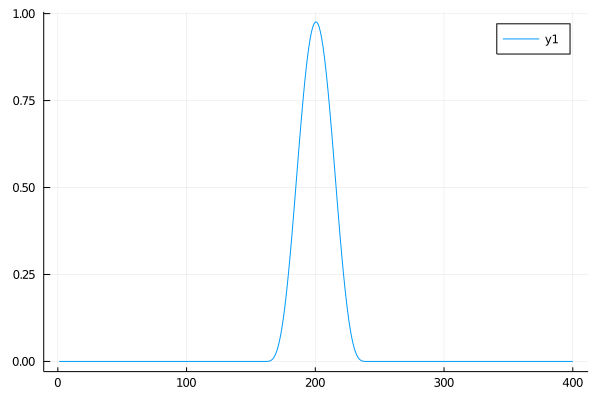

In [14]:
#n = Array(Vector([1.0 for i in 1:N]))
#x = range(0., length=N, step=dx)
#ones = ones(N)

x0 = 0.4; x1 = 0.6
for i in 1:N
    x[i] = dx*(i-1)
    if x[i] > x0 && x[i] < x1
        u0[i] = (x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250
    end
end

plot(u0)

We define now the two problems, for different accuracy. 

In [15]:
@time prob2 = ODEProblem(F2_sbp!,u0,(0.0,T),p);

  0.000232 seconds (331 allocations: 26.547 KiB)


We now solve them:

In [16]:
@time sol2 = solve(prob2,RK4(),dt=dt);

 10.688438 seconds (3.48 M allocations: 11.350 GiB, 22.97% gc time)


Finally we plot the solutions at different times

In [17]:
plot([u0[:],sol2(T*0.1)[:],sol2(T*0.2)[:],sol2(T*0.3)[:],sol2(T*0.4)[:]])

┌ Info: Saved animation to 
│   fn = /Users/reula/Docencia/PDE2020/pde/Tarea_3/wave_anim_fps20.gif
└ @ Plots /Users/reula/.julia/packages/Plots/hyS17/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Docencia/PDE2020/pde/Tarea_3/wave_anim_fps20.gif")
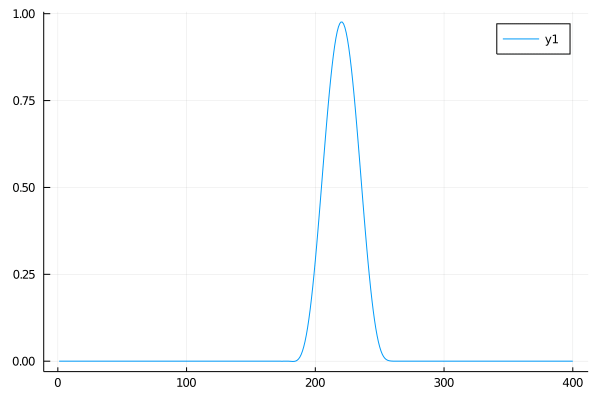

In [21]:
anim = @animate for i ∈ 1:60
    #plot(sol2(T*0.005*i)[:,1], yaxis = ("u", (-1,1)))
    plot(sol2(T*0.005*i)[:,1])
end

gif(anim, "wave_anim_fps20.gif", fps = 5)
    

In [12]:
#plot([r0[:,1],sol2(T)[:,1],sol(T)[:,1]])
#plot(x,sol.u)